### F1 lap time prediction

Today, I have 24 hours to gather, analyse and train all race data (including lap times, circuit infos, pit_stops, etc) since the start of the 2011 season.
The main objective is to make a prediction of the following lap time for a given car. 

If we succeed, we can try to expend the prediction with two new features :
    - Predict the lap time at lap l+n, l being the last lap completed (to predict the degradation, etc)
    - Predict the lap time at lap l+n, with a pit stop at lap l+m with m<n

Let start by gathering data from the "Formula 1 World Championship (1950 - 2023)" Kaggle : https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020

In [324]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None


In [325]:
lap_times = pd.read_csv("../data/lap_times.csv")
pit_stops = pd.read_csv("../data/pit_stops.csv")
races = pd.read_csv("../data/races.csv")
drivers = pd.read_csv("../data/drivers.csv")

#### Lap times

Here is out main dataset !
We can find every lap of every driver of every gp from the start of 1996 season to the end of 2022 season

Later, we should try to add 2023 first three GPs in the dataset

In [326]:
lap_times.sort_values("raceId")

,raceId,driverId,lap,position,time,milliseconds
343807,1,18,38,1,1:28.438,88438
343543,1,20,21,2,1:46.868,106868
343544,1,20,22,2,2:38.375,158375
343545,1,20,23,2,2:31.909,151909
343546,1,20,24,2,2:22.185,142185
...,...,...,...,...,...,...
537373,1096,847,25,5,1:30.665,90665
537372,1096,847,24,5,1:30.765,90765
537371,1096,847,23,5,1:30.663,90663
537377,1096,847,29,5,1:30.471,90471


#### Races

This is the list of every gp from the start of 2009 to the end of 2023, it will be usefull to have some info about the circuit

In [327]:
races.sort_values(["year", "round"])

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
832,833,1950,1,9,British Grand Prix,1950-05-13,\N,http://en.wikipedia.org/wiki/1950_British_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
833,834,1950,2,6,Monaco Grand Prix,1950-05-21,\N,http://en.wikipedia.org/wiki/1950_Monaco_Grand...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
834,835,1950,3,19,Indianapolis 500,1950-05-30,\N,http://en.wikipedia.org/wiki/1950_Indianapolis...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
835,836,1950,4,66,Swiss Grand Prix,1950-06-04,\N,http://en.wikipedia.org/wiki/1950_Swiss_Grand_...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
836,837,1950,5,13,Belgian Grand Prix,1950-06-18,\N,http://en.wikipedia.org/wiki/1950_Belgian_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,1116,2023,19,69,United States Grand Prix,2023-10-22,19:00:00,https://en.wikipedia.org/wiki/2023_United_Stat...,2023-10-20,17:30:00,2023-10-21,18:00:00,\N,\N,2023-10-20,21:00:00,2023-10-21,22:00:00
1098,1117,2023,20,32,Mexico City Grand Prix,2023-10-29,20:00:00,https://en.wikipedia.org/wiki/2023_Mexico_City...,2023-10-27,18:30:00,2023-10-27,22:00:00,2023-10-28,17:30:00,2023-10-28,21:00:00,\N,\N
1099,1118,2023,21,18,São Paulo Grand Prix,2023-11-05,17:00:00,https://en.wikipedia.org/wiki/2023_S%C3%A3o_Pa...,2023-11-03,14:30:00,2023-11-04,14:30:00,\N,\N,2023-11-03,18:00:00,2023-11-04,18:30:00
1100,1119,2023,22,80,Las Vegas Grand Prix,2023-11-19,06:00:00,https://en.wikipedia.org/wiki/2023_Las_Vegas_G...,2023-11-17,04:30:00,2023-11-17,08:00:00,2023-11-18,04:30:00,2023-11-18,08:00:00,\N,\N


#### Pit_stops

Same as the lap_times, we have here all the pit stops

In [328]:
pit_stops = pit_stops.sort_values("raceId").reset_index(drop=True)
pit_stops

,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,17,2,26,17:44:29,22.520,22520
2,841,4,2,27,17:46:04,24.733,24733
3,841,22,3,28,17:49:07,16.892,16892
4,841,67,2,29,17:49:47,23.100,23100
...,...,...,...,...,...,...,...
9629,1096,840,1,13,17:23:19,21.814,21814
9630,1096,848,1,12,17:21:53,21.793,21793
9631,1096,846,2,42,18:07:36,21.559,21559
9632,1096,817,1,19,17:32:38,21.893,21893


#### Drivers

Just a simple drivers list, with their ids

In [329]:
drivers = drivers.sort_values("driverId").reset_index(drop=True)
drivers

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen
...,...,...,...,...,...,...,...,...,...
852,854,mick_schumacher,47,MSC,Mick,Schumacher,1999-03-22,German,http://en.wikipedia.org/wiki/Mick_Schumacher
853,855,zhou,24,ZHO,Guanyu,Zhou,1999-05-30,Chinese,http://en.wikipedia.org/wiki/Guanyu_Zhou
854,856,de_vries,45,DEV,Nyck,de Vries,1995-02-06,Dutch,http://en.wikipedia.org/wiki/Nyck_de_Vries
855,857,piastri,81,PIA,Oscar,Piastri,2001-04-06,Australian,http://en.wikipedia.org/wiki/Oscar_Piastri


Let's join everything we have !

In [330]:
df_merged = pd.merge(lap_times, drivers, on='driverId')
df_merged = pd.merge(df_merged, races, on='raceId')
#The race ids are not ordered by date
df_merged = df_merged.sort_values(["year", "round", "lap", "position"]).reset_index(drop=True)
df_merged = df_merged[["raceId","year","name", "round", "lap", "driverRef", "driverId", "position", "time_x", "milliseconds", "date", "circuitId"]]
df_merged["time_x"] = df_merged["time_x"].apply(lambda x: '0:' + x if len(x.split(':')) == 2 else x)
df_merged["time_x"] = pd.to_timedelta(df_merged['time_x'])
df_merged

,raceId,year,name,round,lap,driverRef,driverId,position,time_x,milliseconds,date,circuitId
0,224,1996,Australian Grand Prix,1,1,villeneuve,35,1,0 days 00:01:43.702000,103702,1996-03-10,1
1,224,1996,Australian Grand Prix,1,1,damon_hill,71,2,0 days 00:01:44.243000,104243,1996-03-10,1
2,224,1996,Australian Grand Prix,1,1,irvine,56,3,0 days 00:01:44.981000,104981,1996-03-10,1
3,224,1996,Australian Grand Prix,1,1,michael_schumacher,30,4,0 days 00:01:45.188000,105188,1996-03-10,1
4,224,1996,Australian Grand Prix,1,1,alesi,55,5,0 days 00:01:46.506000,106506,1996-03-10,1
...,...,...,...,...,...,...,...,...,...,...,...,...
538116,1096,2022,Abu Dhabi Grand Prix,22,58,ocon,839,7,0 days 00:01:30.021000,90021,2022-11-20,24
538117,1096,2022,Abu Dhabi Grand Prix,22,58,stroll,840,8,0 days 00:01:31.330000,91330,2022-11-20,24
538118,1096,2022,Abu Dhabi Grand Prix,22,58,ricciardo,817,9,0 days 00:01:30.856000,90856,2022-11-20,24
538119,1096,2022,Abu Dhabi Grand Prix,22,58,vettel,20,10,0 days 00:01:30.351000,90351,2022-11-20,24


Let's plot it !

In [331]:
#First, we will watch the lap times of a specific driver, on a specific gp

df_OCO_ABU2022 = df_merged.loc[(df_merged["year"]==2022) & (df_merged["name"]=="Abu Dhabi Grand Prix") & (df_merged["driverRef"]=="ocon")]
df_OCO_ABU2022.head()

,raceId,year,name,round,lap,driverRef,driverId,position,time_x,milliseconds,date,circuitId
537011,1096,2022,Abu Dhabi Grand Prix,22,1,ocon,839,8,0 days 00:01:36.964000,96964,2022-11-20,24
537031,1096,2022,Abu Dhabi Grand Prix,22,2,ocon,839,8,0 days 00:01:32.136000,92136,2022-11-20,24
537051,1096,2022,Abu Dhabi Grand Prix,22,3,ocon,839,8,0 days 00:01:31.385000,91385,2022-11-20,24
537071,1096,2022,Abu Dhabi Grand Prix,22,4,ocon,839,8,0 days 00:01:31.427000,91427,2022-11-20,24
537091,1096,2022,Abu Dhabi Grand Prix,22,5,ocon,839,8,0 days 00:01:31.722000,91722,2022-11-20,24


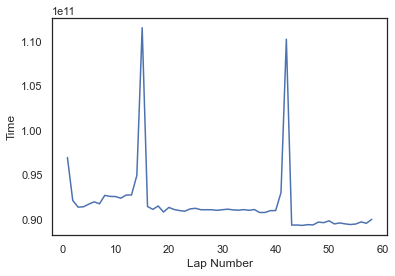

In [332]:
plt.plot(df_OCO_ABU2022["lap"], df_OCO_ABU2022["time_x"], label='Time by lap')
plt.ylabel('Time')
plt.xlabel('Lap Number')
plt.show()

It's easy to see the two pit stops Ocon had. Let's drop those rows to have beter details

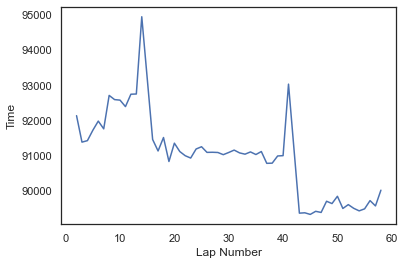

In [333]:
df_OCO_ABU2022_NOSTOP = df_OCO_ABU2022[df_OCO_ABU2022['time_x'] <= pd.Timedelta(minutes=1, seconds=35)]
plt.plot(df_OCO_ABU2022_NOSTOP["lap"], df_OCO_ABU2022_NOSTOP["milliseconds"], label='Time by lap')
plt.ylabel('Time')
plt.xlabel('Lap Number')
plt.show()

As expected, we can see that pit stops are really important in lap time prediction, we are going to had a feature calculating the number of laps since last piststop

In [334]:
df_merged = pd.merge(df_merged, pit_stops, on=['raceId',"lap", "driverId"], how="left")

#actually we don't want to keep the races where there is no pit stops at all

listGpPit = pit_stops["raceId"].unique()
df_merged = df_merged[df_merged['raceId'].isin(listGpPit)]
df_merged.reset_index(drop=True, inplace=True)

df_merged = df_merged[["raceId","year","name", "round", "lap", "driverRef", "driverId", "position", "time_x", "milliseconds_x", "date", "circuitId", "stop"]]

df_merged

,raceId,year,name,round,lap,driverRef,driverId,position,time_x,milliseconds_x,date,circuitId,stop
268807,841,2011,Australian Grand Prix,1,1,vettel,20,1,0 days 00:01:38.109000,98109,2011-03-27,1,NaN
268808,841,2011,Australian Grand Prix,1,1,hamilton,1,2,0 days 00:01:40.573000,100573,2011-03-27,1,NaN
268809,841,2011,Australian Grand Prix,1,1,webber,17,3,0 days 00:01:41.467000,101467,2011-03-27,1,NaN
268810,841,2011,Australian Grand Prix,1,1,petrov,808,4,0 days 00:01:42.835000,102835,2011-03-27,1,NaN
268811,841,2011,Australian Grand Prix,1,1,massa,13,5,0 days 00:01:44.196000,104196,2011-03-27,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
538116,1096,2022,Abu Dhabi Grand Prix,22,58,ocon,839,7,0 days 00:01:30.021000,90021,2022-11-20,24,NaN
538117,1096,2022,Abu Dhabi Grand Prix,22,58,stroll,840,8,0 days 00:01:31.330000,91330,2022-11-20,24,NaN
538118,1096,2022,Abu Dhabi Grand Prix,22,58,ricciardo,817,9,0 days 00:01:30.856000,90856,2022-11-20,24,NaN
538119,1096,2022,Abu Dhabi Grand Prix,22,58,vettel,20,10,0 days 00:01:30.351000,90351,2022-11-20,24,NaN


Let's make a funcion computing the stops :

In [335]:
df = df_merged.copy()
df['stop'] = df.groupby(['raceId', 'driverRef'])['stop'].fillna(method='ffill')
df['stop'] = df['stop'].fillna(0).astype(int)
df

,raceId,year,name,round,lap,driverRef,driverId,position,time_x,milliseconds_x,date,circuitId,stop
268807,841,2011,Australian Grand Prix,1,1,vettel,20,1,0 days 00:01:38.109000,98109,2011-03-27,1,0
268808,841,2011,Australian Grand Prix,1,1,hamilton,1,2,0 days 00:01:40.573000,100573,2011-03-27,1,0
268809,841,2011,Australian Grand Prix,1,1,webber,17,3,0 days 00:01:41.467000,101467,2011-03-27,1,0
268810,841,2011,Australian Grand Prix,1,1,petrov,808,4,0 days 00:01:42.835000,102835,2011-03-27,1,0
268811,841,2011,Australian Grand Prix,1,1,massa,13,5,0 days 00:01:44.196000,104196,2011-03-27,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
538116,1096,2022,Abu Dhabi Grand Prix,22,58,ocon,839,7,0 days 00:01:30.021000,90021,2022-11-20,24,2
538117,1096,2022,Abu Dhabi Grand Prix,22,58,stroll,840,8,0 days 00:01:31.330000,91330,2022-11-20,24,2
538118,1096,2022,Abu Dhabi Grand Prix,22,58,ricciardo,817,9,0 days 00:01:30.856000,90856,2022-11-20,24,1
538119,1096,2022,Abu Dhabi Grand Prix,22,58,vettel,20,10,0 days 00:01:30.351000,90351,2022-11-20,24,1


In [336]:
df["laps_since_last_stop"] = 0
df1 = pd.DataFrame()
for (raceId, driverId), df3 in df.groupby(["raceId", "driverId"]):
    cnt = 0
    nbStop = 0
    for i, row in df3.iterrows():
        cnt += 1
        if row["stop"] == nbStop:
            df3.at[i, "laps_since_last_stop"] = cnt
        else:
            nbStop += 1
            cnt = 0
    df1 = pd.concat([df1, df3], ignore_index=True)
df1

Let's plot this for Ocon's Abu Dhabi 2022 GP

In [ ]:
df_OCO_ABU2022 = df1[(df1["year"]==2022) & (df1["name"]=="Abu Dhabi Grand Prix") & (df1["driverRef"]=="ocon")]
df_OCO_ABU2022.head()

,raceId,year,name,round,lap,driverRef,driverId,position,time_x,milliseconds_x,date,stop,laps_since_last_stop
268663,1096,2022,Abu Dhabi Grand Prix,22,1,ocon,839,8,0 days 00:01:36.964000,96964,2022-11-20,0,1
268664,1096,2022,Abu Dhabi Grand Prix,22,2,ocon,839,8,0 days 00:01:32.136000,92136,2022-11-20,0,2
268665,1096,2022,Abu Dhabi Grand Prix,22,3,ocon,839,8,0 days 00:01:31.385000,91385,2022-11-20,0,3
268666,1096,2022,Abu Dhabi Grand Prix,22,4,ocon,839,8,0 days 00:01:31.427000,91427,2022-11-20,0,4
268667,1096,2022,Abu Dhabi Grand Prix,22,5,ocon,839,8,0 days 00:01:31.722000,91722,2022-11-20,0,5


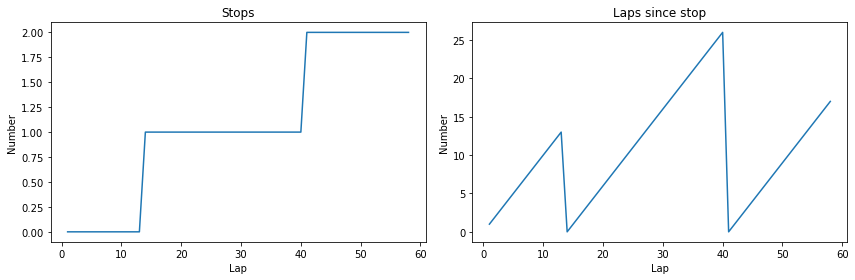

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(df_OCO_ABU2022["lap"], df_OCO_ABU2022["stop"], label='Stops')
axes[0].set_ylabel('Number')
axes[0].set_xlabel('Lap')
axes[0].set_title('Stops')

axes[1].plot(df_OCO_ABU2022["lap"], df_OCO_ABU2022["laps_since_last_stop"], label='Laps since stop')
axes[1].set_ylabel('Number')
axes[1].set_xlabel('Lap')
axes[1].set_title('Laps since stop')

plt.tight_layout() 
plt.show()

### Detection of the most related variables


milliseconds_x          1.000000
stop                    0.015656
position                0.014570
round                   0.000725
driverId               -0.012371
raceId                 -0.032931
year                   -0.033348
lap                    -0.066984
laps_since_last_stop   -0.079637
Name: milliseconds_x, dtype: float64


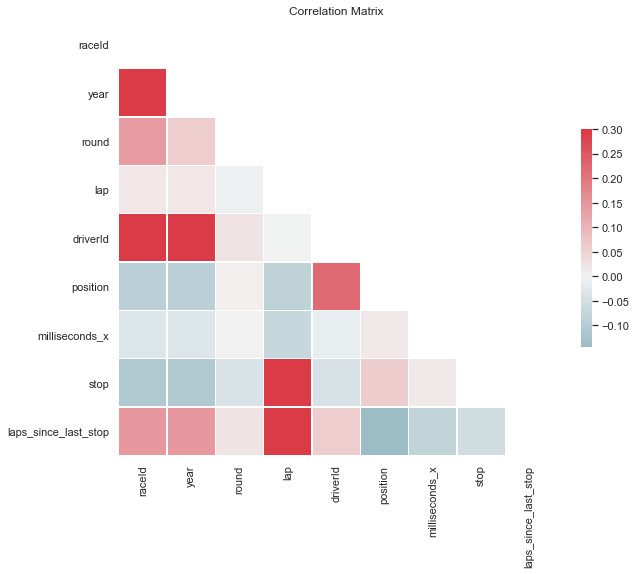

In [ ]:
corr_matrix = df1.corr()
corr_laptime = corr_matrix['milliseconds_x'].sort_values(ascending=False)
print("Correlation between variable and milliseconds (lap time)",corr_laptime)

sns.set(style="white")
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation Matrix')
plt.show()